In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

import lib
import common

In [26]:
def load_exp_interval(x_eval):
    path = "../data/digitized/"

    def load_vals(name: str):
        x, y = (
            pd.read_csv(f"{path}{name}_core2.csv")
            .sort_values("x")
            .reset_index(drop=True)
            .to_numpy()
            .T
        )
        y = np.interp(x_eval, x, y)
        return y / 1000

    y_mean = load_vals("mean")
    y_upper = load_vals("upper_mcmc_PI")
    y_lower = load_vals("lower_mcmc_PI")

    return y_lower, y_mean, y_upper

In [27]:
t_data, y_data = lib.load_exp_data_numpy(name="Core 2")
t_eval = np.linspace(t_data.min(), t_data.max(), 50)

In [28]:
from dataclasses import dataclass

GIVEN_QUANTILE = 0.9

@dataclass
class LikelihoodResult:
    likelihood: np.ndarray
    sigmas: np.ndarray
    mean_gauss: np.ndarray
    bound_gauss_lower: np.ndarray
    bound_gauss_upper: np.ndarray

    def median_likelihood(self):
        return np.median(self.likelihood)

    def mean_likelihood(self, skip: int):
        return np.mean(self.likelihood[skip:])


def compute_loglikelihood_core2_normal(mean, upper, lower):
    c = -stats.norm.ppf((1 - GIVEN_QUANTILE) / 2)
    sigmas = (upper - lower) / (2 * c)
    sigmas[sigmas < 1e-14] = 1e-14
    gauss_upper = mean + c * sigmas
    gauss_lower = mean - c * sigmas

    # interpolation needed because of data_core2_df["c_diss"]
    mean_intp = np.interp(t_data, t_eval, mean)
    sigmas_intp = np.interp(t_data, t_eval, sigmas)
    log_likeli = stats.norm.logpdf(y_data, loc=mean_intp, scale=sigmas_intp)

    return LikelihoodResult(log_likeli, sigmas, mean, gauss_lower, gauss_upper)

TODO: Ich darf nicht das Quantil ausrechnen, indem ich die Punkte zähle. Weil dadurch verbessere ich die Likelihood artifiziell. Siehe dieses Beispiel.

70.9% are in the interval
Likelihood: 7.54e+00
Likelihood: 7.42e+00


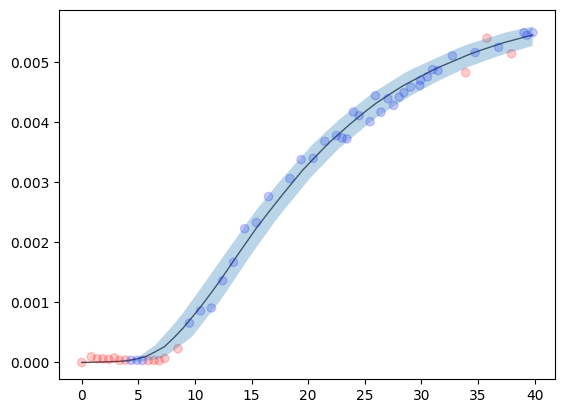

In [29]:
y_lower, y_mean, y_upper = load_exp_interval(t_eval)

is_in_interval = common.is_between_curves(
    t_eval, y_lower, y_upper, np.array([t_data, y_data]).T
)

print(
    f"{np.count_nonzero(is_in_interval)/len(is_in_interval)*100:.1f}% are in the interval"
)
print(
    f"Likelihood: {compute_loglikelihood_core2_normal(y_mean, y_upper, y_lower).median_likelihood():.2e}"
)
print(
    f"Likelihood: {compute_loglikelihood_core2_normal(y_mean, y_upper, y_lower).mean_likelihood(skip=9):.2e}"
)

plt.scatter(t_data, y_data, c=np.where(is_in_interval, "b", "r"), alpha=0.2)
plt.plot(t_eval, y_mean, "k-", zorder=-30, alpha=0.7, lw=1)
plt.fill_between(t_eval, y_lower, y_upper, alpha=0.3)
plt.show()

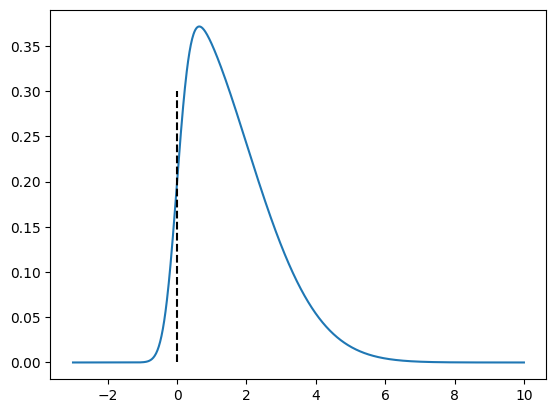

In [30]:
x = np.linspace(-3, 10, 1000)
dist = stats.skewnorm(a=6.4, loc=0, scale=2)
y = dist.pdf(x)

plt.plot(x, y)
plt.vlines(0, 0, 0.3, color="k", linestyle="--")
plt.show()

x% interval means (according to PI3NN):
- x% of data are inside the interval
- x/2% are above median and x/2% are below

In [ ]:
def fit_skew(mean, upper_quantile, lower_quantile, quantile):
    from scipy import optimize

    def loss(a, loc, scale):
        dist = stats.skewnorm(a=a, loc=loc, scale=scale)
        pred_mean = dist.mean()
        pred_upper_quantile, pred_lower_quantile = dist.ppf(
            [upper_quantile, lower_quantile]
        )

In [31]:
mask = x < 3.2897072539029457
np.trapz(y[mask], x[mask])

0.8995419078035993

In [32]:
dist.ppf(0.9)

3.2897072539029457

[2.15035386 2.216579   1.08284497]
True
3.2022124147012246e-11
Mean: 2.999995624478398 (vs. actual: 3)
Area: 0.9000067006760111 (vs. actual: 0.9)


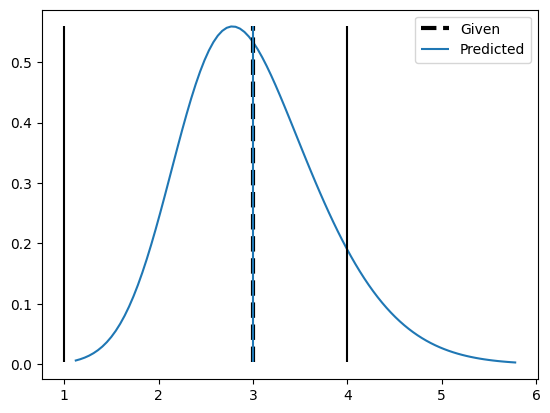

In [47]:
from scipy import optimize

# check if there are multiple solutions that have the given mean and give a x% interval that has the given bounds.
mean = 3
ub = 4
lb = 1

predictive_quality = 0.9


def loss(params):
    a, loc, scale = params
    dist = stats.skewnorm(a=a, loc=loc, scale=scale)
    pred_mean = dist.mean()
    area = dist.cdf(ub) - dist.cdf(lb)
    return (np.square(area - predictive_quality) + np.square(pred_mean - mean)) / 2


def check_correctness(dist):
    print(f"Mean: {dist.mean()} (vs. actual: {mean})")
    print(f"Area: {dist.cdf(ub) - dist.cdf(lb)} (vs. actual: {predictive_quality})")


result = optimize.minimize(loss, x0=[1, 0, 1])
print(result.x)
print(result.success)
print(result.fun)
a, loc, scale = result.x

dist = stats.skewnorm(a=a, loc=loc, scale=scale)
check_correctness(dist)

x = np.linspace(*dist.ppf([0.001, 0.999]), 100)
y = dist.pdf(x)
pred_mean = dist.mean()
# pred_ub

plt.plot(x, y)
plt.vlines(mean, y.min(), y.max(), color="black", linestyles="--", label="Given", lw=3)
plt.vlines([lb, ub], y.min(), y.max(), color="black", linestyles="-")
plt.vlines(pred_mean, y.min(), y.max(), color="C0", label="Predicted")
plt.legend()
plt.show()

[1.36723001 2.36110851 0.99204741]
True
7.095261930743381e-12
Mean: 2.9999965189817956 (vs. actual: 3)
Area: 0.8999985601958042 (vs. actual: 0.9)


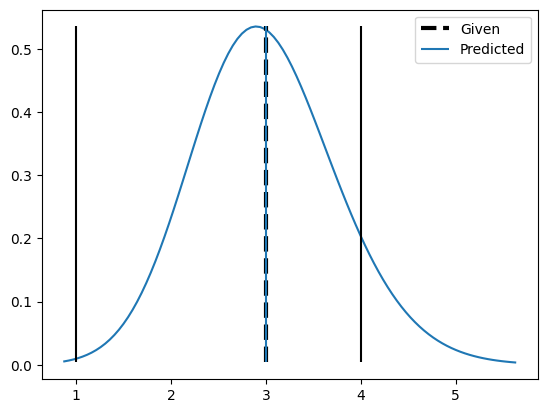

In [49]:
result = optimize.minimize(loss, x0=[0, 0, 1])
print(result.x)
print(result.success)
print(result.fun)
a, loc, scale = result.x

dist = stats.skewnorm(a=a, loc=loc, scale=scale)
check_correctness(dist)

x = np.linspace(*dist.ppf([0.001, 0.999]), 100)
y = dist.pdf(x)
pred_mean = dist.mean()
# pred_ub

plt.plot(x, y)
plt.vlines(mean, y.min(), y.max(), color="black", linestyles="--", label="Given", lw=3)
plt.vlines([lb, ub], y.min(), y.max(), color="black", linestyles="-")
plt.vlines(pred_mean, y.min(), y.max(), color="C0", label="Predicted")
plt.legend()
plt.show()

Wie man sieht, sind das zwei ziemlich unterschiedliche Ergebnisse.

[2.99999661 0.76480626]
True
2.454084235702859e-10
Mean: 2.999996605681189 (vs. actual: 3)
Area: 0.9000218928172457 (vs. actual: 0.9)


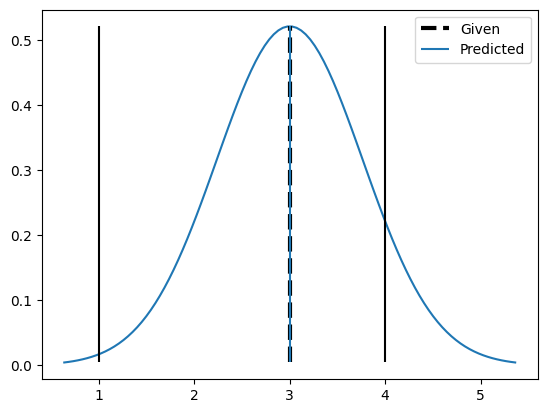

In [51]:
def loss(params):
    loc, scale = params
    dist = stats.norm(loc=loc, scale=scale)
    pred_mean = dist.mean()
    area = dist.cdf(ub) - dist.cdf(lb)
    return (np.square(area - predictive_quality) + np.square(pred_mean - mean)) / 2


result = optimize.minimize(loss, x0=[0, 1])
print(result.x)
print(result.success)
print(result.fun)
loc, scale = result.x

dist = stats.norm(loc=loc, scale=scale)
check_correctness(dist)

x = np.linspace(*dist.ppf([0.001, 0.999]), 100)
y = dist.pdf(x)
pred_mean = dist.mean()
# pred_ub

plt.plot(x, y)
plt.vlines(mean, y.min(), y.max(), color="black", linestyles="--", label="Given", lw=3)
plt.vlines([lb, ub], y.min(), y.max(), color="black", linestyles="-")
plt.vlines(pred_mean, y.min(), y.max(), color="C0", label="Predicted")
plt.legend()
plt.show()

[0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 5 5
 5 5 5 5 5]


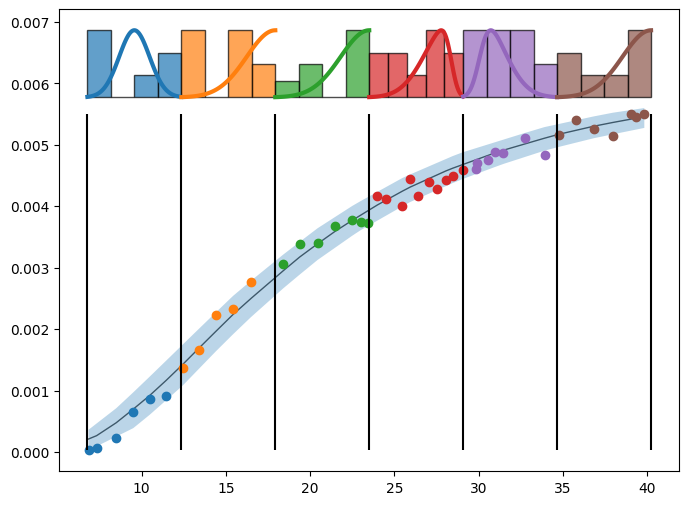

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have loaded data using lib
x, y = lib.load_exp_data_numpy("Core 2")
x = x[13:]
y = y[13:]
y_lower, y_mean, y_upper = load_exp_interval(x)

# Define bins and compute bin indices
bins = np.linspace(x.min() * 0.99, x.max() * 1.01, 7)
bin_width = bins[1] - bins[0]
bin_indices = np.digitize(x, bins) - 1  # Subtract 1 to align indices with bins

# Subset indices for each bin
subset_indices = [np.where(bin_indices == i)[0] for i in range(len(bins) - 1)]

# Create extra space on top for histograms
y_max = y.max()
plt.figure(figsize=(8, 6))

plt.plot(x, y_mean, "k-", zorder=-30, alpha=0.7, lw=1)
plt.fill_between(x, y_lower, y_upper, alpha=0.3)

# Plot the scatter data
plt.vlines(bins, y.min(), y_max, color="black")
for i in range(len(x)):
    plt.scatter(x[i], y[i], color=f"C{bin_indices[i]}")


dists = []

for i, indices in enumerate(subset_indices):
    if len(indices) > 0:
        subset_y = y[indices]

        # Compute histogram for the y values in this subset
        hist, bin_edges = np.histogram(subset_y, bins="auto", density=True)
        hist *= (y_max - y.min()) / hist.max() * 0.2
        bin_edges -= bin_edges.min()
        bin_edges /= bin_edges.max()
        bin_edges *= bin_width
        bin_edges += bins[i]

        # fit a skewnorm
        params = stats.skewnorm.fit(subset_y)
        dist = stats.skewnorm(*params)
        dists.append(dist)
        x_pdf = np.linspace(*dist.ppf([0.001, 0.999]), 100)
        x_plot = x_pdf - x_pdf.min()
        x_plot /= x_plot.max()
        x_plot *= bin_width
        x_plot += bins[i]
        y_pdf = dist.pdf(x_pdf)
        y_plot = 1.05 * y_max + y_pdf * (y_max - y.min()) / y_pdf.max() * 0.2
        plt.plot(x_plot, y_plot, "-", color=f"C{i}", lw=3)

        # Plot the histogram just above the data
        for j in range(len(hist)):
            left = bin_edges[j]
            right = bin_edges[j + 1]
            width = right - left

            # Plot each bar of the histogram horizontally (above the scatter)
            plt.bar(
                x=(left + right) / 2,
                height=hist[j],
                width=width,
                bottom=1.05 * y_max,
                color=f"C{i}",
                alpha=0.7,
                edgecolor="black",
            )

plt.show()

In [145]:
1 - predictive_quality - eps

0.09999999899999998

In [149]:
print(target)
print(dist.ppf(1e-9))
print(dist.ppf(1e-4))
print(dist.ppf(1e-2))
print(dist.ppf(0.05))
print(dist.ppf(1 - predictive_quality - eps))
print(dist.ppf(0.09999999899999998))

0.00040378239282658326
-0.0017193299196096431
-0.0008924044237764698
-0.0003868757360290778
-0.0001394501367173545
-7.534876758601714e-06
-7.534876758601714e-06


True
Final value: 0.0499
1.1e-16
True
Final value: 0.1000
0.0e+00
True
Final value: 0.0814
-3.3e-16
True
Final value: 0.0783
3.3e-16
True
Final value: 0.0625
4.4e-16
True
Final value: 0.0890
0.0e+00


/Users/r/.venvs/p3inn/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:9207: RuntimeWarning: overflow encountered in _skewnorm_ppf
  return _boost._skewnorm_ppf(x, 0, 1, a)


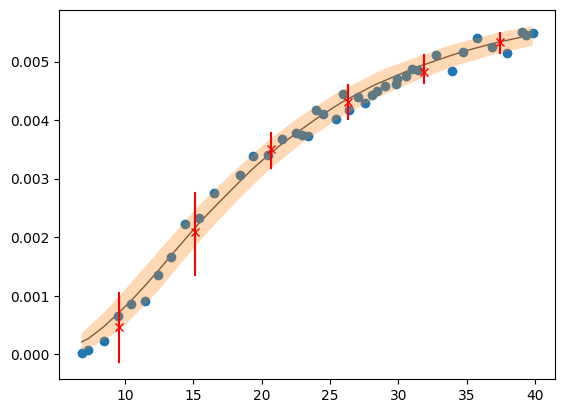

In [155]:
plt.scatter(x, y)

bin_centers = (bins[:-1] + bins[1:]) / 2

for i, dist in enumerate(dists):
    target_lower = np.interp(bin_centers[i], x, y_lower)
    target_upper = np.interp(bin_centers[i], x, y_upper)

    def f(q_low):
        lb, ub = dist.ppf([q_low , q_low + predictive_quality])
        return (abs(lb - target_lower) + abs(ub - target_upper)) / 2

    eps = 1e-9
    result = optimize.minimize(f, eps*2, bounds=[(eps, 1 - predictive_quality - eps)])
    print(result.success)
    start = result.x[0]
    assert start + predictive_quality < 1.0
    lb, ub = dist.ppf([start, start + predictive_quality])

    print(f"Final value: {start:.4f}")
    print(f"{dist.cdf(ub) - dist.cdf(lb) - predictive_quality:.1e}")
    plt.plot(bin_centers[i], dist.mean(), "rx")
    plt.plot([bin_centers[i], bin_centers[i]], [lb, ub], "r-")



plt.plot(x, y_mean, "k-", zorder=-30, alpha=0.7, lw=1)
plt.fill_between(x, y_lower, y_upper, alpha=0.3)
plt.show()